Weather Prediction Project

The goal is to predict the air temperature 2 meters above the ground at a given latitude/longitude and time. The data given is information from weather station measurements and a few weather-forecast model predictions. So, it will be a regression problem. One thing I want to understand from this project is how robust is a regression-based weather prediction model given that the climate is changing, hence the temperature distribution of a given area is changing. The goal will be to see how well different models behave on data that is shifted in time and on climate type. This data set is also part of the Shifts Challenge set up by Yandex.com https://research.yandex.com/shifts/weather to understand how robustness of models and their uncertainty estimates react to distributional shifts in the data.

There are 128 features. The features are of different types and scales. The data can be found at: https://storage.yandexcloud.net/yandex-research/shifts/weather/canonical-trn-dev-data.tar The training data has 3,129,592 entries. There are two sets of development data, 50,000 entries each. The evaluation data has 1,137,731 entries, but it has not been released yet since this is an ongoing comptetition.

The data consists of pairs of meteorological features and air temperature measurements at 2 metres above ground at a particular latitude/longitude and time. The feature vectors include both weather related features such as sun evaluation at the current location, climate values of temperature, pressure and topography, and meteorological parameters on different pressure and surface levels from weather forecast model predictions. Weather forecast model predictions are values produced by the following weather forecast models: Global Forecast System (GFS) ,4 Global Deterministic Forecast System from the Canadian Meteorological Center (CMC),5 and the Weather Research and Forecasting (WRF) Model.6 Each model returns the following predicted values: wind, humidity, pressure, clouds, precipitation, dew point, snow depth, air and soil temperature characteristics. Where applicable, the predictions are given at different isobaric levels from 50 hPa (≈ 20 km above ground) to the ground level. The GFS and WRF models run 4 time a day (0, 6, 12 and 18 GMT), and the CMC model runs twice a day (0 and 12 GMT). Model spatial grid resolution is 0.25◦ × 0.25◦ for GFS and 0.24◦ × 0.24◦ for CMC. The WRF model is calculated for over 60 domains all over the globe, spatial resolution for each domain is 6 × 6 km. Altogether, there are 111 features in total. It is important to note that the features are highly heterogeneous, i.e., they are of different types and scales. The target air temperature values at different locations are taken from about 8K weather stations located across the globe, each of which periodically (≈ each 3 hours) reports a set of measurements. T

To analyze the robustness of learned models to climate shifts, we use the Koppen climate classification [46] that provides publicly available data7 that maps latitudes and longitudes at a 0.5◦ resolution to one of five main climate types: Tropical, Dry, Mild Temperate, Snow and Polar. The climate type is not used as a training feature.

In [1]:
from IPython.display import HTML

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
%matplotlib inline

# Increase default figure and font sizes for easier viewing.
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

In [48]:
# randomly sampling out a fraction of the full data set fro easy managing of code
# The full training data set can be found at:
# ! wget https://storage.yandexcloud.net/yandex-research/shifts/weather/canonical-trn-dev-data.tar
# Note, by downloading the data you agree to it's CC BY SA NC 4.0 license!
#train_full = pd.read_csv("/Users/dinamirijanian/Desktop/train.csv",sep =",") 
#train_cut = train_full.sample(frac=0.0185,random_state=5)
#train_cut.to_csv('data/train_cut.csv',index=False)
#print(train_full.shape)
#train_cut.shape

(3129592, 129)


(57897, 129)

In [49]:
train = pd.read_csv("data/train_cut.csv",sep =",") 
print(train.shape)
train.head()

(57897, 129)


,fact_time,fact_latitude,fact_longitude,fact_temperature,fact_cwsm_class,climate,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,...,cmc_0_1_66_0_grad,cmc_0_1_66_0_next,cmc_0_1_67_0_grad,cmc_0_1_67_0_next,cmc_0_1_68_0_grad,cmc_0_1_68_0_next,gfs_2m_dewpoint_grad,gfs_2m_dewpoint_next,gfs_total_clouds_cover_low_grad,gfs_total_clouds_cover_low_next
0,1.536897e+09,37.807800,-87.685699,19.0,0.0,mild temperate,117.0,-34.127495,22.755714,752.813186,...,0.0,0.00000,0.0,0.000000,0.0,0.0,-0.499939,18.350031,0.0,0.0
1,1.538169e+09,33.630000,-83.850000,27.0,0.0,mild temperate,243.0,29.063373,24.312143,742.794590,...,0.0,0.00000,0.0,0.000000,0.0,0.0,0.595581,20.845575,0.0,0.0
2,1.553684e+09,-41.327202,174.804993,17.0,10.0,mild temperate,16.0,-47.358477,15.566429,758.947841,...,0.0,0.00000,0.0,0.000000,0.0,0.0,-0.496002,14.253992,0.0,0.0
3,1.548590e+09,52.457222,5.519722,5.0,20.0,mild temperate,-5.0,19.261083,3.930000,760.253020,...,0.0,0.61675,0.0,0.137579,0.0,0.0,0.399994,5.249994,63.0,98.0
4,1.548698e+09,34.228889,135.164167,5.0,10.0,mild temperate,7.0,-46.665545,4.299286,754.940419,...,0.0,0.00000,0.0,0.000000,0.0,0.0,-0.953400,-3.150000,21.0,100.0


In [50]:
colnames = list(train.columns)

# Extract out the columns for GFS, WRF and CMC seperately
Each model returns the following predicted values: 
1)wind, 2)humidity, 3)pressure, 4)clouds, 5)precipitation, 6)dew point, 7)now depth, 8)air temp, 9)soil temp 

In [51]:
cmc_list = [s for s in colnames if "cmc_" in s]
gfs_list = [s for s in colnames if "gfs_" in s]
wrf_list = [s for s in colnames if "wrf_" in s]
print(len(cmc_list), "cmc columns")
print(len(gfs_list), "", "gfs columns")
print(len(wrf_list), "", "wrf columns")
print(len(cmc_list) + len(gfs_list) + len(wrf_list),"Total columns")
# The project paper said there are 111 features in total

56 cmc columns
50  gfs columns
13  wrf columns
119 Total columns


In [52]:
print(train[wrf_list].nunique())

wrf_available              2
wrf_t2                 53534
wrf_t2_next            53556
wrf_psfc               53395
wrf_rh2                51453
wrf_wind_u             54850
wrf_wind_v             54850
wrf_rain               17930
wrf_snow                4409
wrf_graupel             1445
wrf_hail                   1
wrf_t2_interpolated    53534
wrf_t2_grad            42271
dtype: int64


# WIll drop wrf_hail from the features because only one value

In [53]:
print(train.shape)
train = train.drop(['wrf_hail'], axis=1)
print(train.shape)

(57897, 129)
(57897, 128)


In [54]:
wrf_list.remove('wrf_hail')
train[wrf_list]

,wrf_available,wrf_t2,wrf_t2_next,wrf_psfc,wrf_rh2,wrf_wind_u,wrf_wind_v,wrf_rain,wrf_snow,wrf_graupel,wrf_t2_interpolated,wrf_t2_grad
0,1.0,293.211609,292.500519,100483.359375,0.956216,-1.438788,-1.895141,0.000000,0.000000e+00,0.0,293.211609,-0.711090
1,1.0,295.579437,295.281616,99315.117188,1.000000,1.185256,1.507214,0.163628,4.130561e-08,0.0,295.579437,-0.297821
2,1.0,289.279938,288.779358,101004.539062,0.768086,1.647477,-0.852767,0.000000,0.000000e+00,0.0,289.279938,-0.500580
3,1.0,278.260620,278.120605,98207.453125,0.932761,-1.405030,2.454028,0.221469,0.000000e+00,0.0,278.260620,-0.140015
4,1.0,277.820679,277.082642,101445.734375,0.735430,0.523683,-3.573148,0.000108,0.000000e+00,0.0,277.820679,-0.738037
...,...,...,...,...,...,...,...,...,...,...,...,...
57892,1.0,287.824097,287.557159,101086.539062,0.886217,-1.673406,2.329940,0.000000,0.000000e+00,0.0,287.824097,-0.266937
57893,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57894,1.0,280.408508,280.025970,101096.031250,0.649375,-1.020862,1.949794,0.000000,0.000000e+00,0.0,280.408508,-0.382538
57895,1.0,299.989288,300.473755,87020.453125,0.527018,2.415941,5.876889,0.295573,0.000000e+00,0.0,299.989288,0.484467


In [55]:
print(train[gfs_list].nunique())

gfs_2m_dewpoint                     18661
gfs_a_vorticity                     56893
gfs_available                           2
gfs_cloudness                         301
gfs_clouds_sea                        206
gfs_horizon_h                          31
gfs_humidity                        12945
gfs_precipitable_water              17382
gfs_precipitations                    292
gfs_pressure                        56101
gfs_r_velocity                      56017
gfs_soil_temperature                40197
gfs_soil_temperature_available          2
gfs_temperature_10000               27037
gfs_temperature_15000               16277
gfs_temperature_20000               16772
gfs_temperature_25000               19159
gfs_temperature_30000               19949
gfs_temperature_35000               23614
gfs_temperature_40000               21450
gfs_temperature_45000               23116
gfs_temperature_5000                 6328
gfs_temperature_50000               22214
gfs_temperature_55000             

In [56]:
train.groupby(by = "gfs_timedelta_s").sum() # 4 times a day in full train data

,fact_time,fact_latitude,fact_longitude,fact_temperature,fact_cwsm_class,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,cmc_0_0_0_1000,...,cmc_0_1_66_0_grad,cmc_0_1_66_0_next,cmc_0_1_67_0_grad,cmc_0_1_67_0_next,cmc_0_1_68_0_grad,cmc_0_1_68_0_next,gfs_2m_dewpoint_grad,gfs_2m_dewpoint_next,gfs_total_clouds_cover_low_grad,gfs_total_clouds_cover_low_next
gfs_timedelta_s,,,,,,,,,,,,,,,,,,,,,
0.0,3.646081e+13,608894.207945,-106840.168265,370534.0,231047.0,7631681.0,-40135.194495,368362.949692,1.721760e+07,6.833477e+06,...,396.464985,6767.509750,32.227416,707.214906,11.376842,168.534488,626.972092,191238.005338,-840.0,402110.0
3600.0,2.665375e+13,479909.272270,-504941.923061,254666.0,148361.0,5270880.0,-56787.843389,256012.976791,1.262349e+07,4.980545e+06,...,296.528790,4981.177605,54.698296,626.401774,11.656303,209.812285,231.104141,135821.909665,3740.0,328135.0
7200.0,2.634507e+13,487966.894485,-524277.824644,247705.0,143429.0,5225323.0,-64272.240953,249660.780142,1.247612e+07,4.917572e+06,...,281.243170,4565.281393,27.509815,500.226690,3.889595,99.116888,244.359741,131175.517657,1399.0,323931.0


In [58]:
print(train[cmc_list].nunique())

cmc_0_0_0_1000              56264
cmc_0_0_0_2_grad            54511
cmc_0_0_0_2_interpolated    57360
cmc_0_0_0_2_next            56617
cmc_0_0_0_2                 56561
cmc_0_0_0_500               55851
cmc_0_0_0_700               55773
cmc_0_0_0_850               56083
cmc_0_0_0_925               56280
cmc_0_0_6_2                 55305
cmc_0_0_7_1000                243
cmc_0_0_7_2                   243
cmc_0_0_7_500               52823
cmc_0_0_7_700                 243
cmc_0_0_7_850                 244
cmc_0_0_7_925                 243
cmc_0_1_0_0                  1859
cmc_0_1_11_0                  278
cmc_0_1_65_0                35308
cmc_0_1_66_0                 5998
cmc_0_1_67_0                 4956
cmc_0_1_68_0                 1013
cmc_0_1_7_0                   399
cmc_0_2_2_10                56897
cmc_0_2_2_1000              57092
cmc_0_2_2_500               57471
cmc_0_2_2_700               57376
cmc_0_2_2_850               57177
cmc_0_2_2_925               57108
cmc_0_2_3_10  

In [59]:
train.groupby(by = "cmc_timedelta_s").sum() # 4 times a day in full train data

,fact_time,fact_latitude,fact_longitude,fact_temperature,fact_cwsm_class,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,cmc_0_0_0_1000,...,cmc_0_1_66_0_grad,cmc_0_1_66_0_next,cmc_0_1_67_0_grad,cmc_0_1_67_0_next,cmc_0_1_68_0_grad,cmc_0_1_68_0_next,gfs_2m_dewpoint_grad,gfs_2m_dewpoint_next,gfs_total_clouds_cover_low_grad,gfs_total_clouds_cover_low_next
cmc_timedelta_s,,,,,,,,,,,,,,,,,,,,,
0.0,3.643004e+13,608494.674190,-106428.664657,370183.0,230806.0,7628369.0,-39891.748862,368002.458264,1.720280e+07,6.833762e+06,...,396.464985,6767.509750,32.227416,707.214906,11.376842,168.534488,638.173996,191018.478397,-692.0,401834.0
3600.0,2.664145e+13,479726.948174,-504929.385258,254518.0,148280.0,5267971.0,-56676.039520,255867.475362,1.261765e+07,4.980835e+06,...,296.528790,4981.177605,54.698296,626.401774,11.656303,209.812285,231.208115,135745.823233,3719.0,327956.0
7200.0,2.632198e+13,487546.168585,-523895.848955,247406.0,143276.0,5222198.0,-64339.817289,249327.293713,1.246503e+07,4.917572e+06,...,281.243170,4565.281393,27.509815,500.226690,3.889595,99.116888,245.386536,130954.075244,1390.0,323529.0


# fact_temperature will be the y of the model. Look at the distributions

In [60]:
devin = pd.read_csv("data/dev_in.csv",sep =",") 
devout = pd.read_csv("data/dev_out.csv",sep =",") 

temperature dataframe size = (57897, 3)


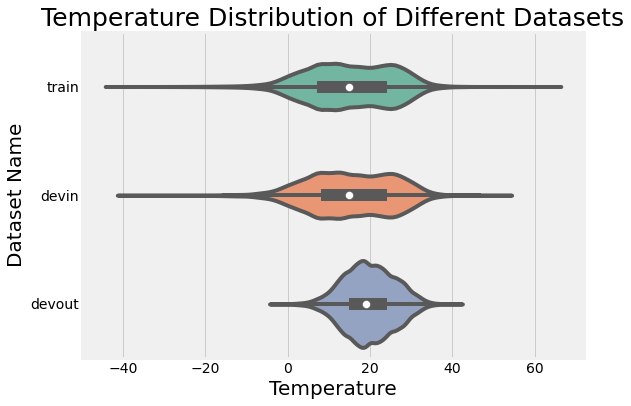

In [61]:
# violin plot of temperature data from all three datasets for plotting
temps = pd.concat([train["fact_temperature"],
                  devin["fact_temperature"],
                  devout["fact_temperature"]],axis=1)
print("temperature dataframe size =",temps.shape)
temps.columns = ["train","devin","devout"]
ax = sns.violinplot(data=temps, palette='Set2',orient ='h')
#ax.tick_params(colors='white')
plt.xlabel("Temperature", size=20)
plt.ylabel("Dataset Name", size=20)
ax.set_title('Temperature Distribution of Different Datasets', fontsize=25);

In [62]:
ax.figure.savefig("Tdist1.png")
#plt.savefig('test1.png') # prints black figure

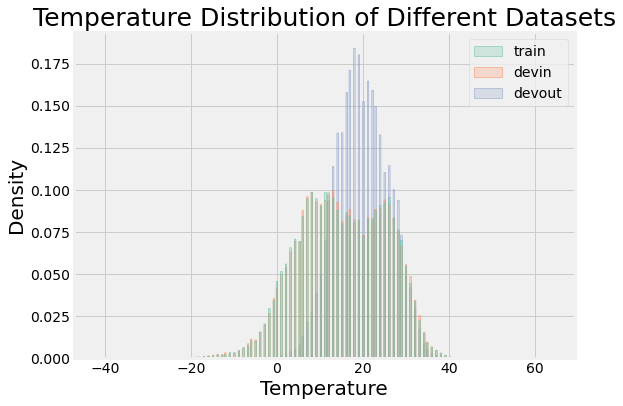

In [63]:
# histogram plots of fact_temperature from training, dev in and dev out.
ax = sns.histplot(data=temps, element="step", stat="density", common_norm=False,
                  palette='Set2',bins = 300)
#ax.tick_params(colors='white')
plt.xlabel("Temperature", size=20)
plt.ylabel("Density", size=20)
ax.set_title('Temperature Distribution of Different Datasets', fontsize=25);

In [64]:
ax.figure.savefig("Tdist2.png")

# Look at the geospacial distribition of data from each set 

In [65]:
def pltcolor(lst):
    cols=[]
    for l in lst:
        if l=='dry':
            cols.append('red')
        elif l=='mild temperate':
            cols.append('blue')
        else:
            cols.append('green')
    return cols

In [66]:
def pltcolor(lst):
    cols=[]
    for l in lst:
        if l=='dry':
            cols.append('red')
        elif l=='mild temperate':
            cols.append('blue')
        elif l=='tropical':
            cols.append('green') # tropical
        elif l=='snow':
            cols.append('black') 
    return cols

In [67]:
devin.climate.unique()

array(['tropical', 'mild temperate', 'dry'], dtype=object)

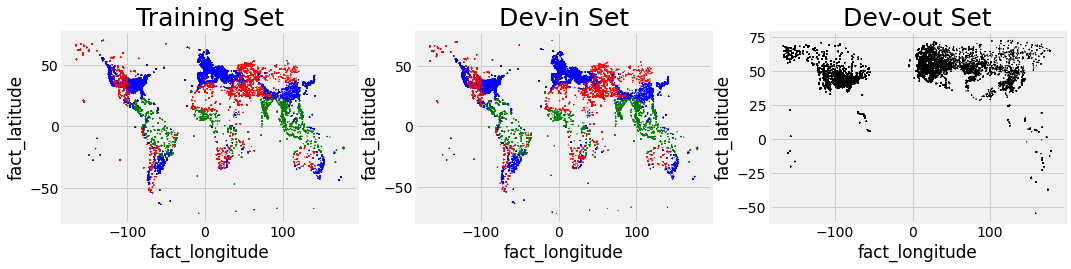

In [68]:
fig, axes = plt.subplots(1,3, figsize=(16,3.5), squeeze=False)
# Create the colors list 
cols=pltcolor(train.climate)
train[['fact_longitude','fact_latitude']].plot(kind = "scatter",
                                               x = "fact_longitude", 
                                               y = "fact_latitude",
                                               s = 0.5, c = cols,
                                               ax=axes[0][0]).set_title('Training Set', 
                                                                       fontsize=25);
cols=pltcolor(devin.climate)
devin[['fact_longitude','fact_latitude']].plot(kind = "scatter",
                                               x = "fact_longitude", 
                                               y = "fact_latitude",
                                               s = 0.5, c = cols,
                                               ax=axes[0][1]).set_title('Dev-in Set', 
                                                                      fontsize=25);
cols=pltcolor(devout.climate)
devout[['fact_longitude','fact_latitude']].plot(kind = "scatter",
                                                x = "fact_longitude", 
                                                y = "fact_latitude",
                                                s = 0.5, c = cols,
                                                ax=axes[0][2]).set_title('Dev-out Set', 
                                                                        fontsize=25);

In [69]:
ax.figure.savefig("Tdist3.png")

# Take a look at the missingness in training set

In [70]:
import missingno as msno

In [71]:
train = train.reindex(sorted(train.columns), axis=1)

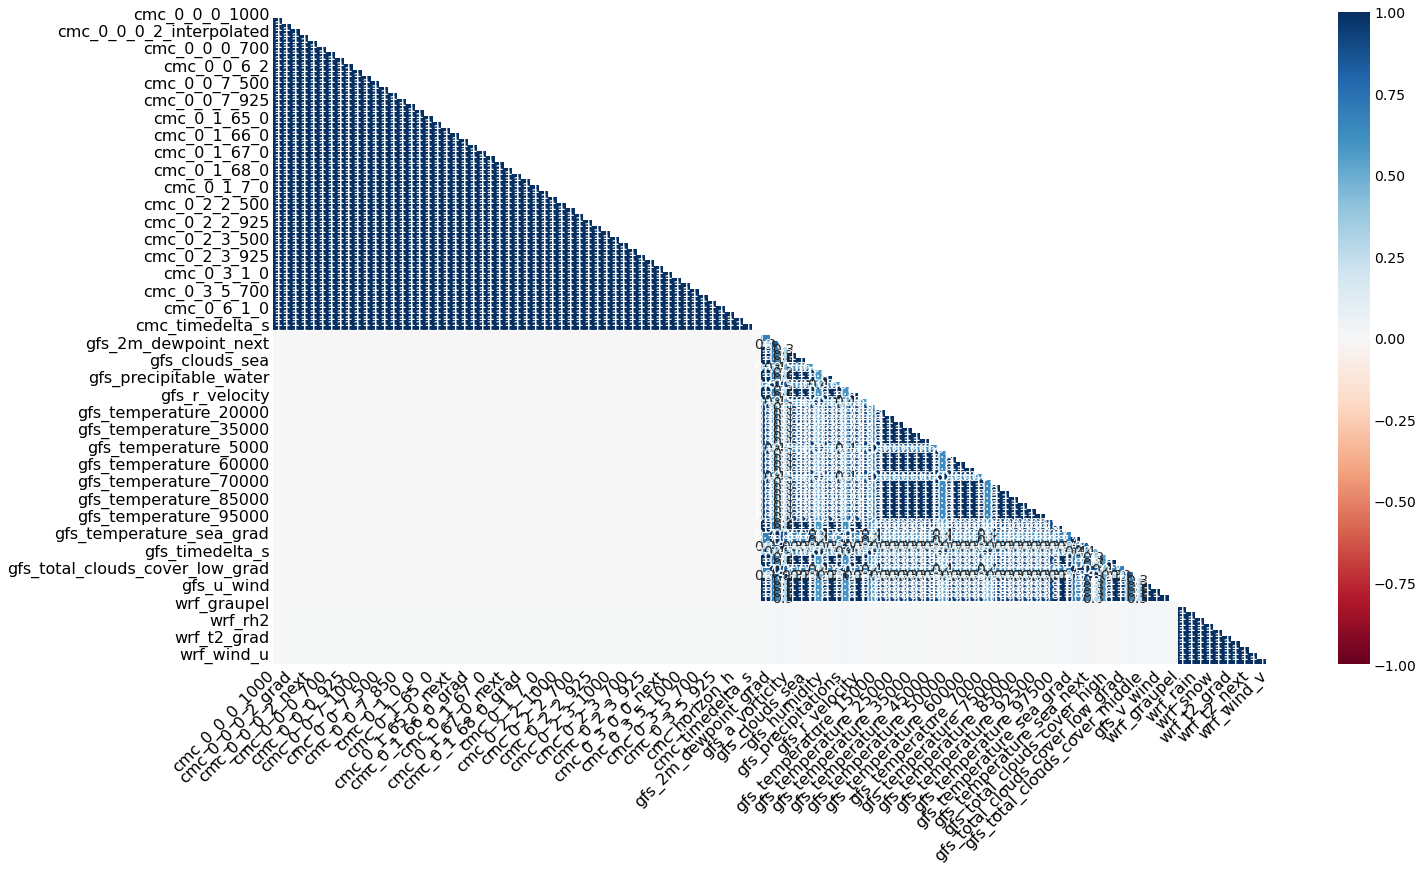

In [72]:
mat = msno.heatmap(train, inline=False)

Mostly. it looks like measurements from each set of experiments are missing together. 
So, cmc_ data is mostly missing with itself, gfs_ data missing with itself and wrf_ data missing with itself. This just means that some time/location measurements are missing information from one experiment or another.

Are the missing data related to climate type?

0
(3066, 128)


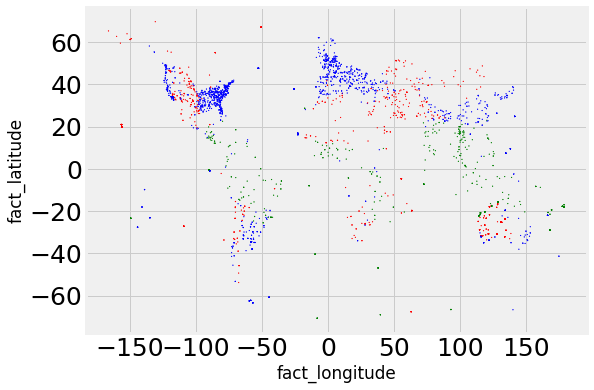

In [73]:
print(train.climate.isnull().sum())
# make a data fram if any row has missing data from gfs measurements
missing_train = train[train.isnull().any(axis='columns')]
print(missing_train.shape)

# Create the colors list 
cols=pltcolor(missing_train.climate)

missing_train[['fact_longitude','fact_latitude']].plot(kind = "scatter",
                                               x = "fact_longitude", 
                                               y = "fact_latitude", c= cols,
                                               s = 0.5, fontsize=25);

The missing data is not confined to a partcular geospacial region or climate type.  
This is a good thing.  We may be able to say that for each experiment the data is missing at random wrt to location.
Actually check for each experiment type seperately now. 

number of rows with wrf_ missing data =  3017
fraction of missing wrf_ rows =  0.052109781163099986


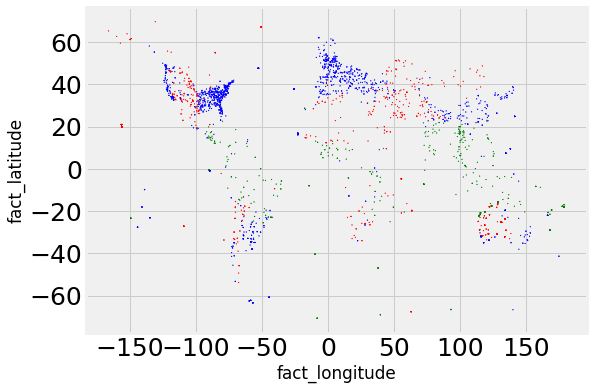

In [74]:
# get train where wrf_ data is missing
wrf_missing = train[train[wrf_list].isnull().any(axis = 'columns')]
print("number of rows with wrf_ missing data = ",len(wrf_missing))
print("fraction of missing wrf_ rows = ",len(wrf_missing)/len(train))
cols=pltcolor(wrf_missing.climate)

wrf_missing[['fact_longitude','fact_latitude']].plot(kind = "scatter",
                                               x = "fact_longitude", 
                                               y = "fact_latitude", c= cols,
                                               s = 0.5, fontsize=25);

number of rows with wrf_ missing data =  13
fraction of missing wrf_ rows =  0.00022453667720261845


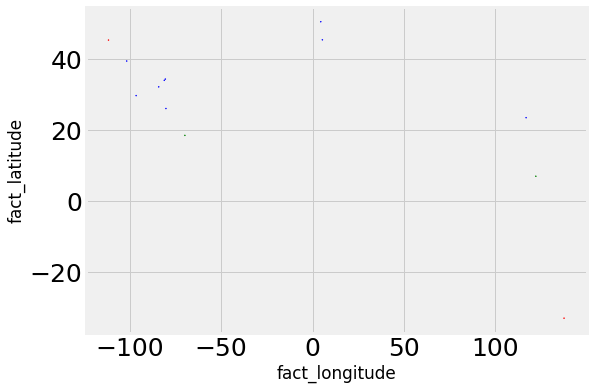

In [75]:
# get train where gfs_ data is missing
gfs_missing = train[train[gfs_list].isnull().any(axis = 'columns')]
print("number of rows with wrf_ missing data = ",len(gfs_missing))
print("fraction of missing wrf_ rows = ",len(gfs_missing)/len(train))
cols=pltcolor(gfs_missing.climate)

gfs_missing[['fact_longitude','fact_latitude']].plot(kind = "scatter",
                                               x = "fact_longitude", 
                                               y = "fact_latitude", c= cols,
                                               s = 0.9, fontsize=25);

number of rows with wrf_ missing data =  45
fraction of missing wrf_ rows =  0.00077724234416291


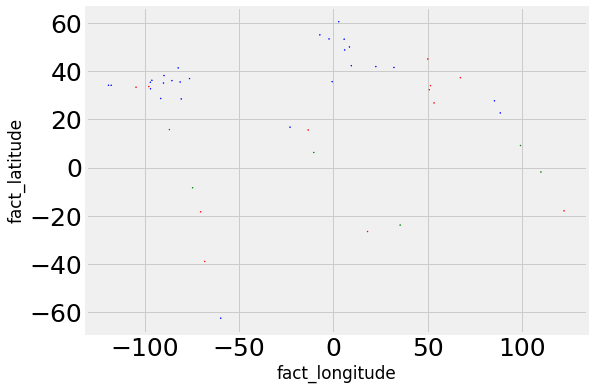

In [76]:
# get train where cmc_ data is missing
cmc_missing = train[train[cmc_list].isnull().any(axis = 'columns')]
print("number of rows with wrf_ missing data = ",len(cmc_missing))
print("fraction of missing wrf_ rows = ",len(cmc_missing)/len(train))
cols=pltcolor(cmc_missing.climate)

cmc_missing[['fact_longitude','fact_latitude']].plot(kind = "scatter",
                                               x = "fact_longitude", 
                                               y = "fact_latitude", c= cols,
                                               s = 0.9, fontsize=25);

We can say that for each experiment individually, the data is missing at random wrt to location and climate type.
We now check if the for each experiment the data is missing at randoom wrt time of day.

In [77]:
# Look at cmc_timedelta_s and gfs_timedelta_s
print(train["gfs_timedelta_s"].unique())
print(train["cmc_timedelta_s"].unique())

[   0. 7200. 3600.   nan]
[   0. 7200. 3600.   nan]


Are the missing cmc_ data missing at random wrt to gfs_timedelta_s 
                             AND
Are the missing gfs_ data missing at random wrt to cmc_timedelta_s?

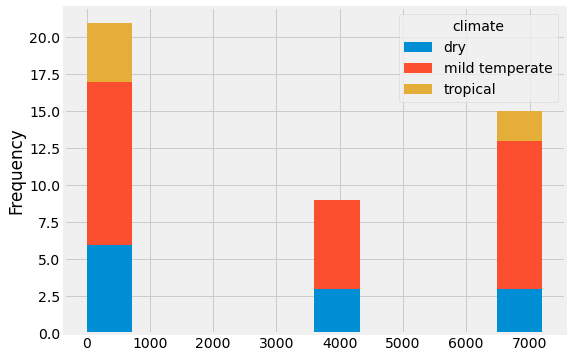

In [78]:
cmc_missing.pivot(columns='climate').gfs_timedelta_s.plot(kind = 'hist', stacked=True);

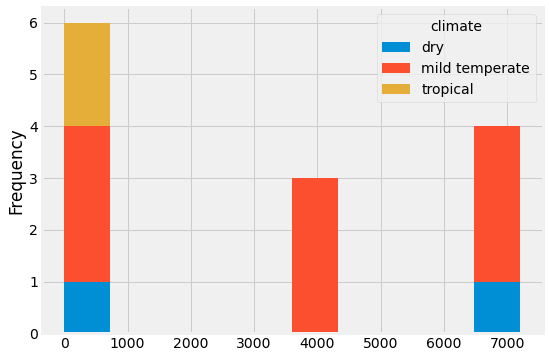

In [79]:
gfs_missing.pivot(columns='climate').cmc_timedelta_s.plot(kind = 'hist', stacked=True);

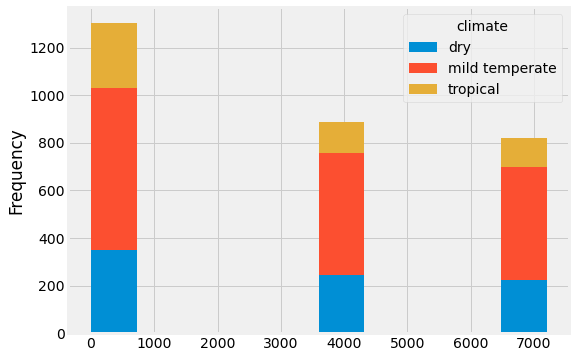

In [80]:
wrf_missing.pivot(columns='climate').cmc_timedelta_s.plot(kind = 'hist', stacked=True);

For the full train set, there is a bit more concentration of missingness at the *_timedelta_s = 0 value for each of the experiments.
But, it is not by an overwhelming amount.  Hence, I will conclude that the data is missing at random in terms of time of day. Also it is missing at random wrt time of day for each climate type.